# SQL資料更新

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
DB_Host = "192.168.1.16"
DB_Name = "X01"
DB_User = "cm23357868"#以我的帳號為例，請填入您個人帳號
DB_Password = "86875332"#以我的密碼為例，請填入您個人密碼

print("Connecting to database using pyodbc...")

db = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server}; SERVER=' + DB_Host + '; DATABASE=' + DB_Name + '; UID=' + DB_User + '; PWD=' + DB_Password)

print("Succesfully Connected to database using pyodbc!")

cursor = db.cursor()
#假設我有個列表(tuple也可以)裡面有股票代號，示範只導入前十項

s_code_df = pd.read_excel("C:\\Users\\larryx30\\Desktop\\ALLSTOCK.xlsx")
stock_ls = list(s_code_df.loc[0:,'NUM'])
data_ls = []
data_frame = pd.DataFrame()
for stock_code in tqdm(stock_ls):
    query1 = """SELECT  [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[資使用率]
      ,[融資維持率(%%)]
      FROM [X01].[dbo].[日融資券排行] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """ %stock_code
    query2 = """SELECT [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[開盤價]
      ,[最高價]
      ,[最低價]
      ,[收盤價]
      ,[成交金額(千)]
      FROM [X01].[dbo].[日收盤表排行] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """ %stock_code
    query3 = """SELECT [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[還原收盤價]
      FROM [X01].[dbo].[日報酬率比較表] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """  %stock_code
    query4 = """SELECT [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[投信買賣超金額(千)]
      ,[投信持股比率(%%)]
      ,[投信持股市值(百萬)]
      ,[投信持股成本]
      FROM [X01].[dbo].[日投信明細與排行] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """  %stock_code
    query5 = """SELECT [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[外資買賣超金額(千)]
      ,[外資持股比率(%%)]
      ,[外資持股市值(百萬)]
      ,[外資持股成本]
      FROM [X01].[dbo].[日外資持股與排行] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """  %stock_code
    
    df_Financing = pd.read_sql(query1, db)#.dropna()
    df_price = pd.read_sql(query2, db)
    df_res_price = pd.read_sql(query3, db)
    df_sit = pd.read_sql(query4, db)
    df_ff = pd.read_sql(query5, db)
    df_from_sql = df_price.merge(df_Financing, on= ['日期', '股票代號', '股票名稱']).fillna(0)
    df_from_sql = df_from_sql.merge(df_res_price, on= ['日期', '股票代號', '股票名稱']).fillna(0)
    df_from_sql = df_from_sql.merge(df_sit,on = ['日期', '股票代號', '股票名稱']).fillna(0)
    df_from_sql = df_from_sql.merge(df_ff,on = ['日期', '股票代號', '股票名稱']).fillna(0)
    df_from_sql['日期'] = pd.to_datetime(df_from_sql['日期'],format = "%Y%m%d").fillna(0)
    df_from_sql = df_from_sql.set_index('日期')
    data_ls.append(df_from_sql)
    data_frame = pd.concat([data_frame,df_from_sql],axis = 0)
    


Connecting to database using pyodbc...
Succesfully Connected to database using pyodbc!


100%|██████████| 1776/1776 [1:33:23<00:00,  3.16s/it]  


# 整理樞紐1

In [2]:
feature_ls = data_frame.columns[3:]
data_frame = data_frame.reset_index(drop = False)
data_pivots_ls = []
for feature in tqdm(feature_ls):
    data_pivot = data_frame.pivot('日期','股票代號',feature)
    data_pivots_ls.append(data_pivot)
data_dict = {str(stock_ls[i]):data_ls[i] for i in range(len(stock_ls))}
    

100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


# 整理樞紐2及字典合併

In [3]:
pivot_dict = {str(feature_ls[i]):data_pivots_ls[i] for i in range(len(feature_ls))}
data_dict.update(pivot_dict)

# 回測樣本代號

In [4]:
response1 = pd.read_excel(r"C:\Users\larryx30\Desktop\\ALLSTOCK.xlsx")
response1.index = response1.index+1
AS = response1['NUM']
response2 = pd.read_excel(r"C:\Users\larryx30\Desktop\\TCRINEW.xlsx")
response2.index = response2.index+1
SKTCRI = response2['NUM']
response3 = pd.read_excel(r"C:\Users\larryx30\Desktop\\STOCKFUTURE.xlsx")
response3.index = response3.index+1
SF = response3['NUM']
DDW = {}
for j in tqdm(AS):
    DDW[str(j)] = data_dict[str(j)].resample('W-FRI').agg({'開盤價':'first', '最高價':'max', '最低價':'min', '收盤價':'last','成交金額(千)':'sum','資使用率':'last','融資維持率(%)':'last', '還原收盤價':'last','投信持股比率(%)':'last','投信持股成本':'last','外資持股比率(%)':'last','外資持股成本':'last','投信持股市值(百萬)':'last'})
for fi in tqdm(AS):
    DDW[str(fi)] = DDW[str(fi)].fillna(method = 'pad' ,axis = 0)

100%|██████████| 1776/1776 [00:00<00:00, 12539.85it/s]


In [5]:
DDW['2330'].tail(3)

,開盤價,最高價,最低價,收盤價,成交金額(千),資使用率,融資維持率(%),還原收盤價,投信持股比率(%),投信持股成本,外資持股比率(%),外資持股成本,投信持股市值(百萬)
日期,,,,,,,,,,,,,
2022-09-02,497.0,505.0,485.0,485.0,89657591,0.41,159.644501,482.22,0.61,524.07,71.64,322.75,76266.76
2022-09-09,485.0,491.5,472.0,475.0,53665551,0.42,157.117203,472.28,0.61,523.68,71.55,323.24,75244.30
2022-09-16,485.0,495.0,476.0,480.0,34620871,0.41,159.208298,477.25,0.61,523.44,71.56,323.69,76140.99


# 計算大盤夏普

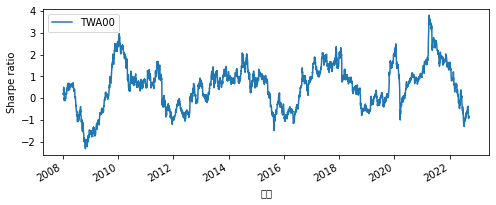

In [6]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
shar2 = pd.DataFrame()

change2 = data_dict["TWA00"]["還原收盤價"].pct_change()
sigma2 = change2.std()
data_dict["TWA00"]['rolling_ret'] = change2.rolling(252).mean()
data_dict["TWA00"]['rolling_std'] = change2.rolling(252).std()
data_dict["TWA00"]['sharpe'] = (data_dict["TWA00"]['rolling_ret'] / data_dict["TWA00"]['rolling_std']) * (252 ** 0.5)

APT2 = data_dict["TWA00"]["sharpe"]
APT2.name = 'TWA00'
DDW['TWA00']["sharpe"] = data_dict['TWA00']['sharpe'].groupby(pd.Grouper(freq='1W')).tail(1)
if len(shar2) == 0:
    shar2 = APT2
else:
    shar2 = pd.merge(shar2,APT2,left_on = shar2.index,right_on = APT2.index,how = 'outer')
    shar2.set_index('key_0',inplace = True)

plt.figure(figsize=(8,3))
plt.xlabel("time")
plt.ylabel("Sharpe ratio")
shar2.plot(label = "TWA00")
plt.legend()

# 計算全股票夏普

100%|██████████| 1776/1776 [00:40<00:00, 43.75it/s]


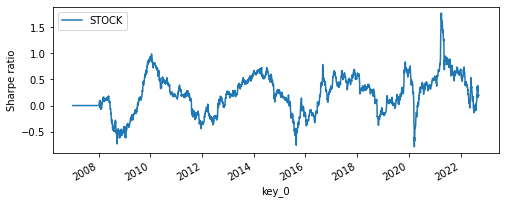

In [7]:
#Sharpe
shar = pd.DataFrame()

for i in tqdm(AS):
    change = data_dict[str(i)]["還原收盤價"].pct_change()
    sigma = change.std()
    data_dict[str(i)]['rolling_ret'] = change.rolling(252).mean()
    data_dict[str(i)]['rolling_std'] = change.rolling(252).std()
    data_dict[str(i)]['sharpe'] = (data_dict[str(i)]['rolling_ret'] / data_dict[str(i)]['rolling_std']) * (252 ** 0.5)

    APT = data_dict[str(i)]["sharpe"]
    APT.name = i

    if len(shar) == 0:
        shar = APT
    else:
        shar = pd.merge(shar,APT,left_on = shar.index,right_on = APT.index,how = 'outer')
        shar.set_index('key_0',inplace = True)

plt.figure(figsize=(8,3))
plt.xlabel("time")
plt.ylabel("Sharpe ratio")
wholesharpe = shar.sort_index().sum(axis = 1)/len(shar.columns)
wholesharpe.plot(label = "STOCK")
plt.legend()
plt.savefig("一籃子夏普")

# 母關鍵點策略

100%|██████████| 1100/1100 [02:24<00:00,  7.60it/s]


Text(0, 0.5, 'Profit')

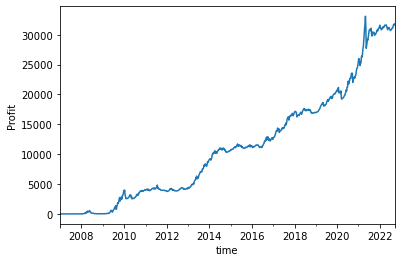

In [8]:
import talib
ERROR = []
trr = pd.DataFrame()
pz = pd.DataFrame()

for x in tqdm(SKTCRI):
    
    DDW[str(x)]['MAX52'] = DDW[str(x)]["還原收盤價"].rolling(52).max()
    DDW[str(x)]["MAX52S"] = DDW[str(x)]["MAX52"].shift(1)
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    KPBS = 0
    KPBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]["還原收盤價"].iloc[z]  > DDW[str(x)]["MAX52S"].iloc[z] and  DDW[str(x)]["成交金額(千)"].iloc[z] > 50000 and  DDW[str(x)]["資使用率"].iloc[z] < 15  :
        
            KPBS = 1

        elif DDW[str(x)]["4MA"].iloc[z] < DDW[str(x)]["4MAS"].iloc[z] and DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['最低價'].shift(1).iloc[z] :
            KPBS = 0
            #buy.append("0")
        KPBUY.append(KPBS)
    DDW[str(x)]["KPBUY"] = KPBUY
    DDW[str(x)]["KPBUYS"] = DDW[str(x)]["KPBUY"].shift(1)
    pzb = DDW[str(x)]["KPBUYS"]  
    pzb.name = str(x)
    pzbs = DDW[str(x)]["KPBUY"]
    pzbs.name = str(x)
    DDW[str(x)]["KPRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["KPBUYS"].dropna().astype(int)
    PT = DDW[str(x)]["KPRR"]
    PT.name = str(x)
    if len(trr) == 0:
        trr = PT
    else:
        trr = pd.merge(trr,PT,left_on = trr.index,right_on = PT.index,how = 'outer')
        trr.set_index('key_0',inplace = True)
    if len(pz) == 0:
        pz = pzbs
    else:
        pz = pd.merge(pz,pzbs,left_on = pz.index,right_on = pzbs.index,how = 'outer')
        pz.set_index('key_0',inplace = True)

trrb =trr.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")


# 整理多單買賣訊01值

85.57439024390244
0.0
462.0


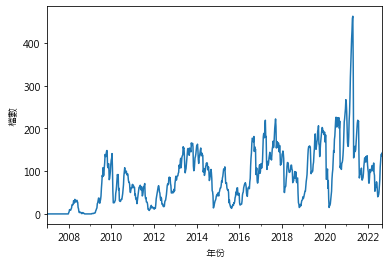

In [9]:
pz1 = pz.sort_index()
f = lambda x :float(x)
pz2 = pz1.applymap(f)
pz3 = pz2.sum(axis=1)
pz4 = pz3.groupby(pd.Grouper(freq='1W')).tail(1)
plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
print(pz4.mean())
print(pz4.min())
print(pz4.max())
pz4.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('多方部位變化表.png')


# 填寫資料更新日期

In [57]:
當週日期 = '2022-09-16'
前週日期 = '2022-09-09'

# 關鍵點當週買進部位

In [58]:
關鍵點持有部位 = pz2.loc[當週日期][(pz2.loc[當週日期]==1)]
關鍵點買進 = pz2.loc[當週日期][(pz2.loc[當週日期]==1) & (pz2.loc[前週日期]==0)]
關鍵點賣出 = pz2.loc[當週日期][(pz2.loc[當週日期]==0) & (pz2.loc[前週日期]==1)]
print("關鍵點買進標的")
print(關鍵點買進)
print("關鍵點買進檔數" , len(關鍵點買進))
print("關鍵點持有部位數目" , len(關鍵點持有部位))
print("關鍵點賣出部位")
print(關鍵點賣出)
print("關鍵點賣出檔數" , len(關鍵點賣出))


關鍵點買進標的
2105    1.0
2221    1.0
2483    1.0
4119    1.0
4155    1.0
4417    1.0
6139    1.0
6146    1.0
6245    1.0
6432    1.0
8088    1.0
Name: 2022-09-16 00:00:00, dtype: float64
關鍵點買進檔數 11
關鍵點持有部位數目 143
關鍵點賣出部位
2313    0.0
3303    0.0
Name: 2022-09-16 00:00:00, dtype: float64
關鍵點賣出檔數 2


# 關鍵點歷年損益

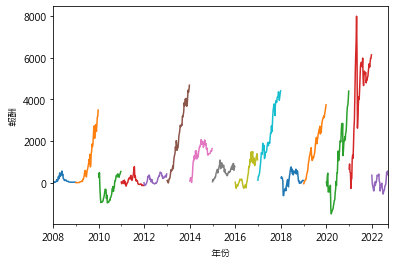

In [59]:
yl = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for h in yl :
    trrt = trr.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtfig = trrt.plot()
trrtfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfig.savefig('主模型歷年損益.png')

# 放空補丁策略

100%|██████████| 1100/1100 [03:08<00:00,  5.84it/s]


<AxesSubplot:xlabel='key_0'>

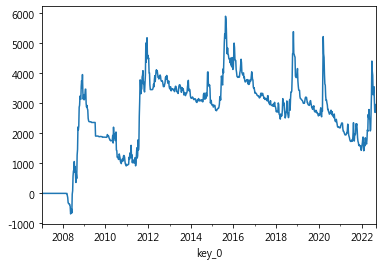

In [13]:
import talib
ERROR = []
trrs = pd.DataFrame()
pzs = pd.DataFrame()

for x in tqdm(SKTCRI):
    
    DDW[str(x)]['LOW5'] = DDW[str(x)]["最低價"].rolling(2).min()
    DDW[str(x)]['SMAX3'] = DDW[str(x)]["最高價"].rolling(2).max()
    DDW[str(x)]["LOW5S"] = DDW[str(x)]["LOW5"].shift(1)
    DDW[str(x)]["4SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=4, matype=0)
    DDW[str(x)]["COVERMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=8, matype=0)
    DDW[str(x)]["SCHECKMA"] = talib.MA(DDW[str(x)]["收盤價"].dropna(), timeperiod=20, matype=0)
    DDW[str(x)]["4SELLMAS"] = DDW[str(x)]["4SELLMA"].shift(1)
    DDW[str(x)]["30SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=30, matype=0)
    DDW[str(x)]["60SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=60, matype=0)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    DDW['TWA00']['4SELLHMA'] = talib.MA(DDW['TWA00']["收盤價"].dropna(), timeperiod=2, matype=0)
    DDW['TWA00']['20SELLHMA'] = talib.MA(DDW['TWA00']["收盤價"].dropna(), timeperiod=20, matype=0)
    DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    BSS = 0
    SELL =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]['成交金額(千)'].iloc[z] > 100000 and DDW[str(x)]["30SELLMA"].iloc[z] < DDW[str(x)]["30SELLMA"].shift(1).iloc[z] \
        and DDW[str(x)]["還原收盤價"].iloc[z]  <  DDW[str(x)]["60SELLMA"].iloc[z] and DDW[str(x)]["SCHECKMA"].iloc[z] < DDW[str(x)]["SCHECKMA"].shift(4).iloc[z] \
        and DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['LOW5S'].iloc[z]  and DDW[str(x)]['融資維持率(%)'].iloc[z] > 135 and DDW[str(x)]['資使用率'].iloc[z] > 3 \
         :
            BSS = -1

        elif   (DDW[str(x)]['還原收盤價'].iloc[z] > DDW[str(x)]['COVERMA'].iloc[z] and DDW[str(x)]['COVERMA'].iloc[z] > DDW[str(x)]['COVERMA'].shift(1).iloc[z]) \
        or DDW[str(x)]['融資維持率(%)'].iloc[z] < 135 :
            BSS = 0
        # or 
        #DDW[str(x)]['收盤價'].iloc[z] > DDW[str(x)]['最高價'].shift(4).iloc[z] or
        #if  DDW['TWA00']['4SELLHMA'].iloc[z] > DDW['TWA00']['20SELLHMA'].iloc[z]  :
            #BSS = 0
            
        SELL.append(BSS)
    DDW[str(x)]["SELL"] = SELL
    DDW[str(x)]["SELLS"] = DDW[str(x)]["SELL"].shift(1)
    ps = DDW[str(x)]["SELLS"]  
    ps.name = str(x)
    pss = DDW[str(x)]["SELL"]
    pss.name = str(x)
    DDW[str(x)]["SRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["SELLS"].dropna().astype(int)
    PTS = DDW[str(x)]["SRR"]
    PTS.name = str(x)
    if len(trrs) == 0:
        trrs = PTS
    else:
        trrs = pd.merge(trrs,PTS,left_on = trrs.index,right_on = PTS.index,how = 'outer')
        trrs.set_index('key_0',inplace = True)
    if len(pzs) == 0:
        pzs = pss
    else:
        pzs = pd.merge(pzs,pss,left_on = pzs.index,right_on = pss.index,how = 'outer')
        pzs.set_index('key_0',inplace = True)

trrsp = trrs.sort_index().sum(axis = 1).cumsum()
trrsp.plot()

# 整理空單買賣訊01值

-43.93658536585366
-145.0
0.0


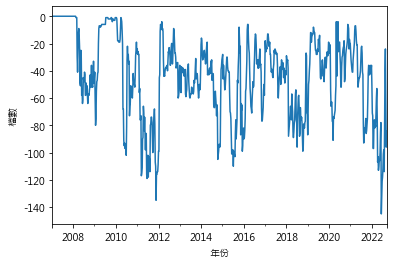

In [60]:
pzs1 = pzs.sort_index()
f1 = lambda x :float(x)
pzs2 = pzs1.applymap(f1)
pzs3 = pzs2.sum(axis=1)
pzs4 = pzs3.groupby(pd.Grouper(freq='1W')).tail(1)
print(pzs4.mean())
print(pzs4.min())
print(pzs4.max())
pzs4.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('空方部位變化表.png')

# 空單當週放空部位

In [61]:
空單放空部位 = pzs2.loc[當週日期][(pzs2.loc[當週日期]== -1)]
空單放空 = pzs2.loc[當週日期][(pzs2.loc[當週日期]== -1) & (pzs2.loc[前週日期]==0)]
空單回補 = pzs2.loc[當週日期][(pzs2.loc[當週日期]==0) & (pzs2.loc[前週日期]==-1)]
print("空單放空標的")
print(空單放空)
print("空單放空檔數" , len(空單放空))
print("空單持有空單部位數目" , len(空單放空部位))
print("空單回補部位")
print(空單回補)
print("空單回補檔數" , len(空單回補))

空單放空標的
3221   -1.0
6491   -1.0
Name: 2022-09-16 00:00:00, dtype: float64
空單放空檔數 2
空單持有空單部位數目 84
空單回補部位
2329    0.0
2457    0.0
2607    0.0
3016    0.0
3217    0.0
3260    0.0
3526    0.0
3704    0.0
3714    0.0
4968    0.0
6438    0.0
6509    0.0
8255    0.0
Name: 2022-09-16 00:00:00, dtype: float64
空單回補檔數 13


# 空單歷年損益

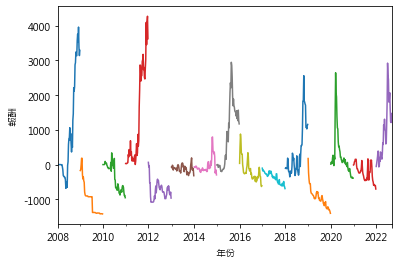

In [62]:

yl = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for h in yl :
    trrts = trrs.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtsfig = trrts.plot()
trrtsfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfig.savefig('空單歷年損益.png')

# 台積電策略

,開盤價,最高價,最低價,收盤價,成交金額(千),資使用率,融資維持率(%),還原收盤價,投信持股比率(%),投信持股成本,...,MAXNS,MINN2330,MINNS,2330MA,2330SMA,2330LMA,出場價,BUY2330,BUY2330S,2330RR
日期,,,,,,,,,,,,,,,,,,,,,
2022-07-15,468.0,494.0,449.5,492.5,87577222,0.45,160.307007,489.68,0.56,526.18,...,498.13,450.90,450.90,531.0285,536.2620,531.0285,433.0,0,0.0,0.000000
2022-07-22,495.5,505.0,486.5,503.0,73948506,0.42,164.319794,500.12,0.56,525.80,...,489.68,450.90,450.90,526.7595,531.0285,526.7595,433.0,0,0.0,0.000000
2022-07-29,500.0,510.0,491.0,509.0,60449457,0.40,166.494400,506.08,0.57,525.31,...,500.12,464.32,450.90,523.7730,526.7595,523.7730,433.0,0,0.0,0.000000
2022-08-05,506.0,516.0,488.5,516.0,79612324,0.38,169.247604,513.04,0.59,524.78,...,506.08,489.68,464.32,520.6975,523.7730,520.6975,433.0,0,0.0,0.000000
2022-08-12,510.0,518.0,499.5,517.0,57766953,0.38,169.583405,514.04,0.59,524.61,...,513.04,500.12,489.68,516.8315,520.6975,516.8315,449.5,0,0.0,0.000000
2022-08-19,520.0,527.0,517.0,519.0,54978043,0.37,169.916199,516.03,0.61,524.58,...,514.04,506.08,500.12,513.5100,516.8315,513.5100,486.5,1,0.0,0.000000
2022-08-26,511.0,515.0,502.0,512.0,42004744,0.37,167.669403,509.07,0.60,524.41,...,516.03,509.07,506.08,510.9280,513.5100,510.9280,488.5,1,1.0,-1.348759
2022-09-02,497.0,505.0,485.0,485.0,89657591,0.41,159.644501,482.22,0.61,524.07,...,516.03,482.22,509.07,507.2510,510.9280,507.2510,488.5,0,1.0,-5.274324
2022-09-09,485.0,491.5,472.0,475.0,53665551,0.42,157.117203,472.28,0.61,523.68,...,516.03,472.28,482.22,503.2745,507.2510,503.2745,485.0,0,0.0,-0.000000


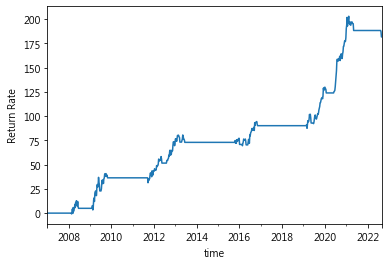

In [17]:
import talib
ERROR = []
trr2330 = pd.DataFrame()
pz2330 = pd.DataFrame()


    
DDW['2330']['MAXN2330'] = DDW['2330']["還原收盤價"].rolling(4).max()
DDW['2330']["MAXNS"] = DDW['2330']["MAXN2330"].shift(1)
DDW['2330']['MINN2330'] = DDW['2330']["還原收盤價"].rolling(4).min()
DDW['2330']["MINNS"] = DDW['2330']["MINN2330"].shift(1)
DDW['2330']["2330MA"] = talib.MA(DDW['2330']["還原收盤價"].dropna(), timeperiod=20, matype=0)
DDW['2330']["2330SMA"] = DDW['2330']["2330MA"].shift(1)
DDW['2330']["2330LMA"] = talib.MA(DDW['2330']["還原收盤價"].dropna(), timeperiod=20, matype=0)
DDW['2330']["DR"] = ((DDW['2330']["還原收盤價"] - DDW['2330']["還原收盤價"].shift(1))/DDW['2330']["還原收盤價"].shift(1))*100
DDW['TWA00']['4SHMA'] = talib.MA(DDW['TWA00']["sharpe"].dropna(), timeperiod=4, matype=0)
DDW['TWA00']['20SHMA'] = talib.MA(DDW['TWA00']["sharpe"].dropna(), timeperiod=20, matype=0)
DDW['2330']['出場價'] = DDW['2330']["最低價"].rolling(4).min().shift(1)
BS2330 = 0
BUY2330 =[]
for z in range(len(DDW['2330'])):

    if  DDW['2330']["還原收盤價"].iloc[z]  >  DDW['2330']["2330MA"].iloc[z] and DDW['2330']['收盤價'].iloc[z] > DDW['2330']['最高價'].rolling(2).max().shift(1).iloc[z] \
    and   DDW['TWA00']['4SHMA'].iloc[z] < 0.3 :
         BS2330 = 1

    elif  DDW['2330']["收盤價"].iloc[z] < DDW['2330']["出場價"].iloc[z]   :
        BS2330 = 0
        
    
        BS2330 = 0
        #buy.append("0")
    BUY2330.append(BS2330)
DDW['2330']["BUY2330"] = BUY2330
DDW['2330']["BUY2330S"] = DDW['2330']["BUY2330"].shift(1)
pz2330 = DDW['2330']["BUY2330S"]  
pz2330.name = '2330'
pzz2330 = DDW['2330']["BUY2330"]
pzz2330.name = '2330'
DDW['2330']["2330RR"] = DDW['2330']["DR"] * DDW['2330']["BUY2330S"].dropna().astype(int)
PTS2330 = DDW['2330']["2330RR"]
PTS2330.name = '2330'
if len(trr2330) == 0:
    trr2330 = PTS2330
else:
    trr2330 = pd.merge(trr2330,PTS2330,left_on = trrs.index,right_on = PTS.index,how = 'outer')
    trr2330.set_index('key_0',inplace = True)

trr2330fig = trr2330.cumsum().plot()
trr2330fig = plt.gcf()
plt.xlabel("time")
plt.ylabel("Return Rate")
trr2330fig.savefig('2330')
DDW['2330'].tail(10)

# 全市場夏普處理與合併

In [18]:
# 日期處理及設定reblance間隔

#設定rebalance頻率及sharpe觀察日數
rebalance = 52

#設定納入股票檔數
count = 10
fee = 2
#主程式
shar = pd.DataFrame()

#計算個股Sharpe ratio
for i in tqdm(DDW.keys()):
    change = DDW[str(i)]["還原收盤價"].pct_change()
    sigma = change.std()
    DDW[str(i)]['rolling_ret'] = change.rolling(rebalance).mean()
    DDW[str(i)]['rolling_std'] = change.rolling(rebalance).std()
    DDW[str(i)]['sharpe105'] = DDW[str(i)]['rolling_ret'] / DDW[str(i)]['rolling_std']
    APT = DDW[str(i)]["sharpe105"]
    APT.name = str(i)

    if len(shar) == 0:
        shar = APT
    else:
        shar = pd.merge(shar,APT,left_on = shar.index,right_on = APT.index,how = 'outer')
        shar.set_index('key_0',inplace = True)
        shar.index.name = '日期'
shar1 = shar.quantile(0.99,axis= 1)
shar2 = pd.DataFrame(shar1.sort_index()).rename(columns = {0.99:'sharp1'})
for key in tqdm(DDW.keys()):
    DDW[key] =  DDW[key].merge(shar2,left_index=True,right_index = True,how='left')
DDW['2330'].tail(1)

100%|██████████| 1776/1776 [00:01<00:00, 1208.11it/s]


,開盤價,最高價,最低價,收盤價,成交金額(千),資使用率,融資維持率(%),還原收盤價,投信持股比率(%),投信持股成本,...,2330SMA,2330LMA,出場價,BUY2330,BUY2330S,2330RR,rolling_ret,rolling_std,sharpe105,sharp1
日期,,,,,,,,,,,,,,,,,,,,,
2022-09-16,485.0,495.0,476.0,480.0,34620871,0.41,159.208298,477.25,0.61,523.44,...,503.2745,500.5355,472.0,0,0.0,0.0,-0.003595,0.028501,-0.126142,0.315983


# 去除多欄(資料多_X才處理)

In [19]:
#for key in tqdm(DDW.keys()):
    #DDW[key] = DDW[key].drop(columns = ['sharp1_x','sharp1_y'])

# M夏普策略

100%|██████████| 1100/1100 [05:14<00:00,  3.50it/s]


<AxesSubplot:xlabel='key_0'>

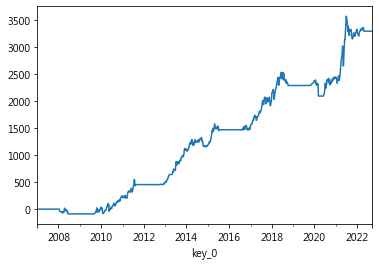

In [20]:
import talib
ERROR = []
trrmsharpe = pd.DataFrame()
pzmsp = pd.DataFrame()
for x in tqdm(SKTCRI):
    
    BQT = 0
    BUYQT =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]['sharpe105'].iloc[z] > DDW[str(x)]['sharp1'].iloc[z]  and DDW[str(x)]['成交金額(千)'].iloc[z] > 30000 and DDW[str(x)]['sharpe105'].iloc[z] > 0 \
        and DDW[str(x)]['資使用率'].iloc[z] < 30 and DDW[str(x)]['大盤夏普'].iloc[z] > 0.4 :
            BQT = 1

        elif   DDW[str(x)]["收盤價"].iloc[z] < DDW[str(x)]["最低價"].shift(1).rolling(4).min().iloc[z] or DDW[str(x)]['大盤夏普'].iloc[z] < 0:
            BQT = 0
        
        #if  DDW['TWA00']['4SELLHMA'].iloc[z] > DDW['TWA00']['20SELLHMA'].iloc[z]  :
            #BSS = 0
            
        BUYQT.append(BQT)
    DDW[str(x)]["BUYQT"] = BUYQT
    DDW[str(x)]["BUYQTS"] = DDW[str(x)]["BUYQT"].shift(1)
    tqt = DDW[str(x)]["BUYQTS"]  
    tqt.name = str(x)
    pqt = DDW[str(x)]["BUYQT"]
    pqt.name = str(x)
    DDW[str(x)]["QTRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["BUYQTS"].dropna().astype(int)
    PQT = DDW[str(x)]["QTRR"]
    PQT.name = str(x)    
    if len(trrmsharpe) == 0:
        trrmsharpe = PQT
    else:
        trrmsharpe = pd.merge(trrmsharpe,PQT,left_on = trrmsharpe.index,right_on = PQT.index,how = 'outer')
        trrmsharpe.set_index('key_0',inplace = True)
    if len(pzmsp) == 0:
        pzmsp = pqt
    else:
        pzmsp = pd.merge(pzmsp,pqt,left_on = pzmsp.index,right_on = pqt.index,how = 'outer')
        pzmsp.set_index('key_0',inplace = True)

tqt1 = trrmsharpe.sort_index().sum(axis = 1).cumsum()
tqt1.plot()

# 整理夏普買賣訊01值

8.136585365853659
0.0
28.0


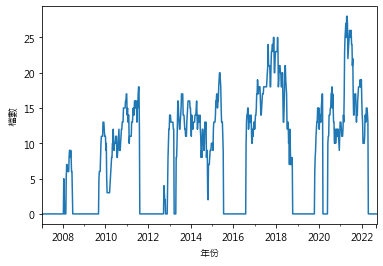

In [63]:
夏普1 = pzmsp.sort_index()
f2 = lambda x :float(x)
夏普2 = 夏普1.applymap(f2)
夏普3 = 夏普2.sum(axis=1)
夏普部位 =夏普3.groupby(pd.Grouper(freq='1W')).tail(1)
print(夏普部位.mean())
print(夏普部位.min())
print(夏普部位.max())
夏普部位.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('空方部位變化表.png')

# M夏普當週買進部位

In [64]:
M夏普持有部位 = 夏普2.loc[當週日期][夏普2.loc[當週日期] ==1]
M夏普買進 = 夏普2.loc[當週日期][(夏普2.loc[當週日期] ==1) & (夏普2.loc[前週日期] ==0)]
M夏普賣出 = 夏普2.loc[當週日期][(夏普2.loc[當週日期] ==0) & (夏普2.loc[前週日期] ==1)]
print("M夏普買進標的")
print(M夏普買進)
print("M夏普買進檔數" , len(M夏普買進))
print("M夏普持有部位數目" , len(M夏普持有部位))
print("M夏普賣出部位")
print(M夏普賣出)
print("M夏普賣出檔數" , len(M夏普賣出))

M夏普買進標的
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
M夏普買進檔數 0
M夏普持有部位數目 0
M夏普賣出部位
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
M夏普賣出檔數 0


# 夏普歷年損益

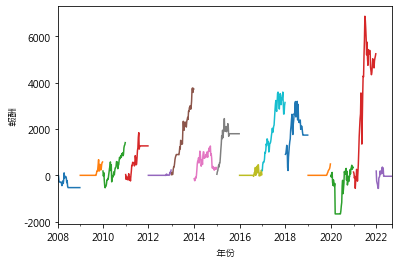

In [23]:
yl = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for h in yl :
    trrtms = trrmsharpe.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtmsfig = (trrtms*6).plot()
trrtmsfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtmsfig.savefig('M夏普歷年損益.png')

# 量能突破策略

100%|██████████| 1100/1100 [05:46<00:00,  3.17it/s]


Text(0, 0.5, 'Profit')

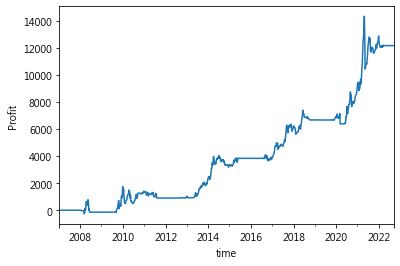

In [24]:
import talib
ERROR = []
trrv = pd.DataFrame()
pvz = pd.DataFrame()

for x in tqdm(SKTCRI):
    
    DDW[str(x)]['SMAX52'] = DDW[str(x)]["還原收盤價"].rolling(4).max()
    DDW[str(x)]["SMAX52S"] = DDW[str(x)]["MAX52"].shift(1)
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    VBS = 0
    VBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]["成交金額(千)"].iloc[z]  > (DDW[str(x)]["成交金額(千)"].shift(1)*1.5).iloc[z] and DDW[str(x)]["成交金額(千)"].iloc[z] > 100000 \
        and DDW[str(x)]["收盤價"].iloc[z]  > (DDW[str(x)]["最高價"].shift(2)*1.1).iloc[z] and DDW[str(x)]['收盤價'].iloc[z] > DDW[str(x)]["SMAX52S"].iloc[z] \
        and DDW[str(x)]['大盤夏普'].iloc[z] > 0.3:
        
            VBS = 1

        elif  DDW[str(x)]["收盤價"].iloc[z] < DDW[str(x)]["最低價"].shift(2).iloc[z] or DDW[str(x)]['大盤夏普'].iloc[z]  < 0.3 :
            VBS = 0
            #buy.append("0")
        VBUY.append(VBS)
    DDW[str(x)]["VBUY"] = VBUY
    DDW[str(x)]["VBUYS"] = DDW[str(x)]["VBUY"].shift(1)
    pzb = DDW[str(x)]["VBUYS"]  
    pzb.name = str(x)
    pvzbs = DDW[str(x)]["VBUY"]
    pvzbs.name = str(x)
    DDW[str(x)]["RR"] = DDW[str(x)]["DR"] * DDW[str(x)]["VBUYS"].dropna().astype(int)
    PVT = DDW[str(x)]["RR"]
    PVT.name = str(x)
    if len(trr) == 0:
        trrv = PVT
    else:
        trrv = pd.merge(trrv,PVT,left_on = trrv.index,right_on = PVT.index,how = 'outer')
        trrv.set_index('key_0',inplace = True)
    if len(pz) == 0:
        pvz = pvzbs
    else:
        pvz = pd.merge(pvz,pvzbs,left_on = pvz.index,right_on = pvzbs.index,how = 'outer')
        pvz.set_index('key_0',inplace = True)

trrv1 =trrv.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")

# 整理量能買賣訊01值

34.44024390243902
0.0
264.0


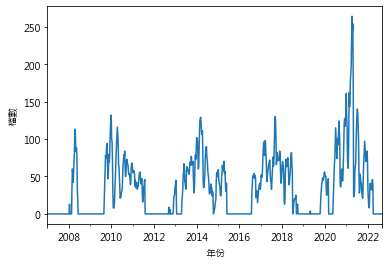

In [66]:
pvz1 = pvz.sort_index()
f4 = lambda x :float(x)
pvz2 = pvz1.applymap(f4)
pvz3 = pvz2.sum(axis=1)
pvz4 = pvz3.groupby(pd.Grouper(freq='1W')).tail(1)
print(pvz4.mean())
print(pvz4.min())
print(pvz4.max())
pvz4.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('量能部位變化表.png')

# <font color="red">量能當週買進部位</font>

In [67]:
#當週日期 = '2022-08-26'
#前週日期 = '2022-08-19'

量能持有部位 = pvz2.loc[當週日期][pvz2.loc[當週日期] ==1]
量能買進 = pvz2.loc[當週日期][(pvz2.loc[當週日期] ==1) & (pvz2.loc[前週日期] ==0)]
量能賣出 = pvz2.loc[當週日期][(pvz2.loc[當週日期] ==0) & (pvz2.loc[前週日期] ==1)]
print("量能買進標的")
print(量能買進)
print("量能買進檔數" , len(量能買進))
print("量能持有部位數目" , len(量能持有部位))
print("量能賣出部位")
print(量能賣出)
print("量能賣出檔數" , len(量能賣出))

量能買進標的
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
量能買進檔數 0
量能持有部位數目 0
量能賣出部位
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
量能賣出檔數 0


# 低接策略

100%|██████████| 1100/1100 [06:09<00:00,  2.98it/s]


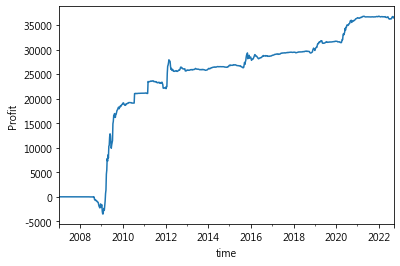

In [27]:
import talib
ERROR = []
trrkd = pd.DataFrame()
pzkd1 = pd.DataFrame()

for x in tqdm(SKTCRI):
    DDW[str(x)]["K"],DDW[str(x)]["D"] = talib.STOCH(DDW[str(x)]['最高價'], 
                              DDW[str(x)]['最低價'], 
                              DDW[str(x)]['收盤價'], 
                              fastk_period=52,
                              slowk_period=10,
                              slowk_matype=1,
                              slowd_period=10,
                              slowd_matype=1)
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    KDBS = 0
    KDBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]["K"].iloc[z] > DDW[str(x)]["D"].iloc[z] and DDW[str(x)]["K"].shift(1).iloc[z] < DDW[str(x)]["D"].shift(1).iloc[z] \
        and DDW[str(x)]['成交金額(千)'].iloc[z] < 500000  \
        and DDW[str(x)]['D'].iloc[z] < 20 and DDW[str(x)]['還原收盤價'].iloc[z] < (DDW[str(x)]['MAX52S']*0.7).iloc[z] :
        
            KDBS = 1

        elif  DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['最低價'].rolling(4).min().shift(1).iloc[z] :
            KDBS = 0
            #buy.append("0")
        KDBUY.append(KDBS)
    DDW[str(x)]["KDBUY"] = KDBUY
    DDW[str(x)]["KDBUYS"] = DDW[str(x)]["KDBUY"].shift(1)
    pzkd = DDW[str(x)]["KDBUYS"]  
    pzkd.name = str(x)
    pzkds = DDW[str(x)]["KDBUY"]
    pzkds.name = str(x)
    DDW[str(x)]["KDRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["KDBUYS"].dropna().astype(int)
    PVKD= DDW[str(x)]["KDRR"]
    PVKD.name = str(x)
    if len(trrkd) == 0:
        trrkd = PVKD
    else:
        trrkd = pd.merge(trrkd,PVKD,left_on = trrkd.index,right_on = PVKD.index,how = 'outer')
        trrkd.set_index('key_0',inplace = True)
    if len(pzkd) == 0:
        pzkd1 = pzkds
    else:
        pzkd1 = pd.merge(pzkd1,pzkds,left_on = pzkd1.index,right_on = pzkds.index,how = 'outer')
        pzkd1.set_index('key_0',inplace = True)

trrkd1 =trrkd.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")
plt.savefig('低接損益')

# 整理低接買賣訊01值

47.08048780487805
0.0
343.0


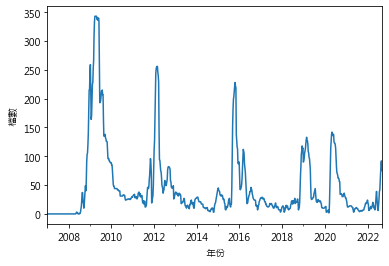

In [68]:
KD1 = pzkd1.sort_index()
f6 = lambda x :float(x)
KD2 = KD1.applymap(f6)
KD3 = KD2.sum(axis=1)
KD部位 =KD3.groupby(pd.Grouper(freq='1W')).tail(1)
print(KD部位.mean())
print(KD部位.min())
print(KD部位.max())
KD部位.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('低接部位變化表.png')

# 低接當週買進部位

In [69]:

低接持有部位 = KD2.loc[當週日期][KD2.loc[當週日期] ==1]
低接買進 = KD2.loc[當週日期][(KD2.loc[當週日期] ==1) & (KD2.loc[前週日期] ==0)]
低接賣出 = KD2.loc[當週日期][(KD2.loc[當週日期] ==0) & (KD2.loc[前週日期] ==1)]
print("低接買進標的")
print(低接買進)
print("低接買進檔數" , len(低接買進))
print("低接持有部位數目" , len(低接持有部位))
print("低接賣出部位")
print(低接賣出)
print("低接賣出檔數" , len(低接賣出))

低接買進標的
2031    1.0
Name: 2022-09-16 00:00:00, dtype: float64
低接買進檔數 1
低接持有部位數目 75
低接賣出部位
3092    0.0
4760    0.0
5215    0.0
5474    0.0
6230    0.0
Name: 2022-09-16 00:00:00, dtype: float64
低接賣出檔數 5


# 融資爆發策略


100%|██████████| 1100/1100 [02:45<00:00,  6.66it/s]


Text(0, 0.5, 'Profit')

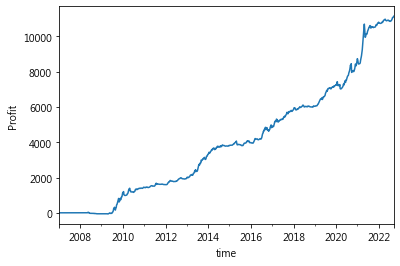

In [30]:
import talib
ERROR = []
trrmm = pd.DataFrame()
pzmm = pd.DataFrame()
pzmm1 = pd.DataFrame()
for x in tqdm(SKTCRI):
    
    
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    MMBS = 0
    MMBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]['融資維持率(%)'].iloc[z] > 170 and DDW[str(x)]['融資維持率(%)'].shift(1).iloc[z] < 170  \
        and  DDW[str(x)]['成交金額(千)'].iloc[z] < 250000 and DDW[str(x)]['K'].iloc[z] > 50 and DDW[str(x)]['資使用率'].iloc[z] < 15 and  DDW[str(x)]['成交金額(千)'].iloc[z] > 10000 :
        
            MMBS = 1

        elif  DDW[str(x)]['還原收盤價'].iloc[z] < DDW[str(x)]['4MA'].iloc[z] or  DDW[str(x)]['融資維持率(%)'].shift(1).iloc[z] < 160 :
            MMBS = 0
            #buy.append("0")
        MMBUY.append(MMBS)
    DDW[str(x)]["MMBUY"] = MMBUY
    DDW[str(x)]["MMBUYS"] = DDW[str(x)]["MMBUY"].shift(1)
    pzmm = DDW[str(x)]["MMBUYS"]  
    pzmm.name = str(x)
    pzmms = DDW[str(x)]["MMBUY"]
    pzmms.name = str(x)
    DDW[str(x)]["MMRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["MMBUYS"].dropna().astype(int)
    PVMM= DDW[str(x)]["MMRR"]
    PVMM.name = str(x)
    if len(trrmm) == 0:
        trrmm = PVMM
    else:
        trrmm = pd.merge(trrmm,PVMM,left_on = trrmm.index,right_on = PVMM.index,how = 'outer')
        trrmm.set_index('key_0',inplace = True)
    if len(pzmm) == 0:
        pzmm1 = pzmms
    else:
        pzmm1 = pd.merge(pzmm1,pzmms,left_on = pzmm1.index,right_on = pzmms.index,how = 'outer')
        pzmm1.set_index('key_0',inplace = True)

trrmm1 =trrmm.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")


# 整理融資爆發買賣訊01值

19.617073170731707
0.0
118.0


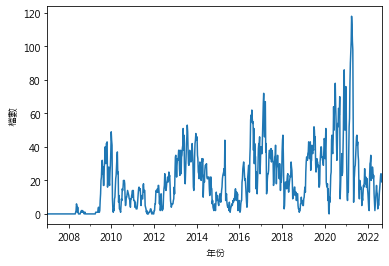

In [70]:
MM1 = pzmm1.sort_index()
f12 = lambda x :float(x)
MM2 = MM1.applymap(f12)
MM3 = MM2.sum(axis=1)
MM部位 =MM3.groupby(pd.Grouper(freq='1W')).tail(1)
print(MM部位.mean())
print(MM部位.min())
print(MM部位.max())
MM部位.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('量能部位變化表.png')

# 融資爆發當週買進部位

In [71]:
MM持有部位 = MM2.loc[當週日期][(MM2.loc[當週日期]==1)]
MM買進 = MM2.loc[當週日期][(MM2.loc[當週日期]==1) & (MM2.loc[前週日期]==0)]
MM賣出 = MM2.loc[當週日期][(MM2.loc[當週日期]==0) & (MM2.loc[前週日期]==1)]
print("MM買進標的")
print(MM買進)
print("MM買進檔數" , len(MM買進))
print("MM持有部位數目" , len(MM持有部位))
print("MM賣出部位")
print(MM賣出)
print("MM賣出檔數" , len(MM賣出))

MM買進標的
1321    1.0
2467    1.0
Name: 2022-09-16 00:00:00, dtype: float64
MM買進檔數 2
MM持有部位數目 20
MM賣出部位
4557    0.0
Name: 2022-09-16 00:00:00, dtype: float64
MM賣出檔數 1


# 外資策略

100%|██████████| 1100/1100 [03:40<00:00,  5.00it/s]


Text(0, 0.5, 'Profit')

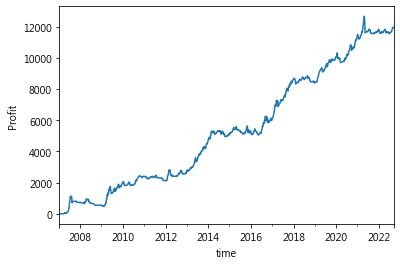

In [33]:
import talib
ERROR = []
trrtest = pd.DataFrame()
pztest = pd.DataFrame()
pztest1 = pd.DataFrame()
for x in tqdm(SKTCRI):
    
    
    DDW[str(x)]["FF4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=10, matype=0)
    DDW[str(x)]["FF4MAS"] = DDW[str(x)]["FF4MA"].shift(1)
    DDW[str(x)]['FFMAX'] = DDW[str(x)]["還原收盤價"].rolling(10).max()
    DDW[str(x)]["FFMAXS"] = DDW[str(x)]["FFMAX"].shift(1)
    DDW[str(x)]["FFMINS"] = DDW[str(x)]["最低價"].rolling(10).min().shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    #DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    TESTBS = 0
    TESTBUY =[]
    for z in range(len(DDW[str(x)])):

        if  DDW[str(x)]['外資持股比率(%)'].iloc[z] > DDW[str(x)]['外資持股比率(%)'].shift(1).iloc[z] and DDW[str(x)]['外資持股比率(%)'].iloc[z] >10 \
        and  DDW[str(x)]['成交金額(千)'].iloc[z] < 700000 and DDW[str(x)]['還原收盤價'].iloc[z] > DDW[str(x)]['FFMAXS'].iloc[z] and  DDW[str(x)]['成交金額(千)'].iloc[z] > 50000 \
        and DDW[str(x)]['外資持股比率(%)'].iloc[z] > DDW[str(x)]['外資持股比率(%)'].shift(5).iloc[z] :
            TESTBS = 1

        elif DDW[str(x)]['還原收盤價'].iloc[z] < (DDW[str(x)]['FF4MA'].iloc[z]) or DDW[str(x)]['收盤價'].iloc[z] < (DDW[str(x)]['FFMINS'].iloc[z]) \
        or (DDW[str(x)]['外資持股比率(%)'].iloc[z] < DDW[str(x)]['外資持股比率(%)'].shift(5).iloc[z] and DDW[str(x)]['還原收盤價'].iloc[z] < DDW[str(x)]['還原收盤價'].shift(3).iloc[z]):
            TESTBS = 0
            #buy.append("0")
        TESTBUY.append(TESTBS)
    DDW[str(x)]["TESTBUY"] = TESTBUY
    DDW[str(x)]["TESTBUYS"] = DDW[str(x)]["TESTBUY"].shift(1)
    pztests = DDW[str(x)]["TESTBUYS"]  
    pztests.name = str(x)
    pztest = DDW[str(x)]["TESTBUY"]
    pztest.name = str(x)
    DDW[str(x)]["TESTRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["TESTBUYS"].dropna().astype(int)
    PVTEST= DDW[str(x)]["TESTRR"]
    PVTEST.name = str(x)
    if len(trrtest) == 0:
        trrtest = PVTEST
    else:
        trrtest = pd.merge(trrtest,PVTEST,left_on = trrtest.index,right_on = PVTEST.index,how = 'outer')
        trrtest.set_index('key_0',inplace = True)
    if len(pztest) == 0:
        pztest1 = pztest
    else:
        pztest1 = pd.merge(pztest1,pztest,left_on = pztest1.index,right_on = pztest.index,how = 'outer')
        pztest1.set_index('key_0',inplace = True)

trrtest1 =trrtest.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")


# 整理外資買賣訊01值

38.39390243902439
0.0
146.0


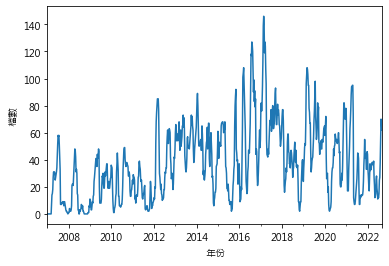

In [72]:
外資1 = pztest1.sort_index()
fsit = lambda x :float(x)
外資2 = 外資1.applymap(fsit)
外資3 = 外資2.sum(axis=1)
外資4 = 外資3.groupby(pd.Grouper(freq='1W')).tail(1)
print(外資4.mean())
print(外資4.min())
print(外資4.max())
外資4.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('外資部位變化表.png')

# 外資當週買進部位

In [73]:
外資持有部位 = 外資2.loc[當週日期][外資2.loc[當週日期] ==1]
外資買進 = 外資2.loc[當週日期][(外資2.loc[當週日期] ==1) & (外資2.loc[前週日期] ==0)]
外資賣出 = 外資2.loc[當週日期][(外資2.loc[當週日期] ==0) & (外資2.loc[前週日期] ==1)]
print("外資買進標的")
print(外資買進)
print("外資買進檔數" , len(外資買進))
print("外資持有部位數目" , len(外資持有部位))
print("外資賣出部位")
print(外資賣出)
print("外資賣出檔數" , len(外資賣出))

外資買進標的
1402    1.0
1717    1.0
5457    1.0
6139    1.0
6269    1.0
6612    1.0
9938    1.0
Name: 2022-09-16 00:00:00, dtype: float64
外資買進檔數 7
外資持有部位數目 64
外資賣出部位
1503    0.0
2504    0.0
3023    0.0
6283    0.0
Name: 2022-09-16 00:00:00, dtype: float64
外資賣出檔數 4


Text(0, 0.5, '報酬')

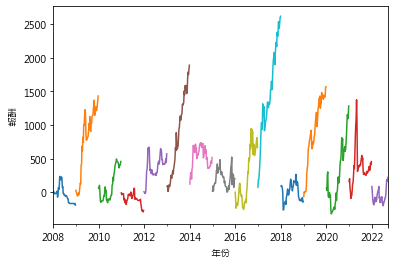

In [74]:
yl = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for h in yl :
    trrtestw = trrtest.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtestfig = (trrtestw).plot()


plt.xlabel("年份")
plt.ylabel("報酬")


In [75]:
print("外資持有部位數目")
print(list(外資持有部位.index))

外資持有部位數目
['1104', '1215', '1319', '1342', '1402', '1410', '1526', '1537', '1582', '1599', '1701', '1707', '1712', '1717', '2066', '2103', '2104', '2355', '2362', '2392', '2402', '2421', '2428', '2439', '2495', '2515', '2548', '2754', '3022', '3376', '3413', '3531', '3611', '3703', '4105', '4107', '4167', '4532', '4536', '4557', '4763', '4906', '4953', '4977', '5284', '5457', '5903', '6121', '6139', '6153', '6269', '6451', '6605', '6612', '6670', '6768', '8105', '8938', '9904', '9907', '9924', '9933', '9938', '9939']


<AxesSubplot:xlabel='日期'>

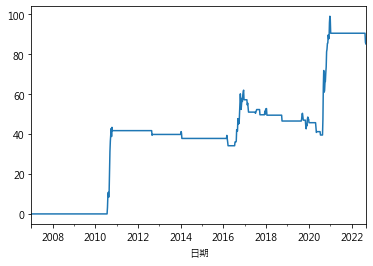

In [38]:
DDW['1304']['TESTRR'].cumsum().plot()

# 以下製圖研究不用

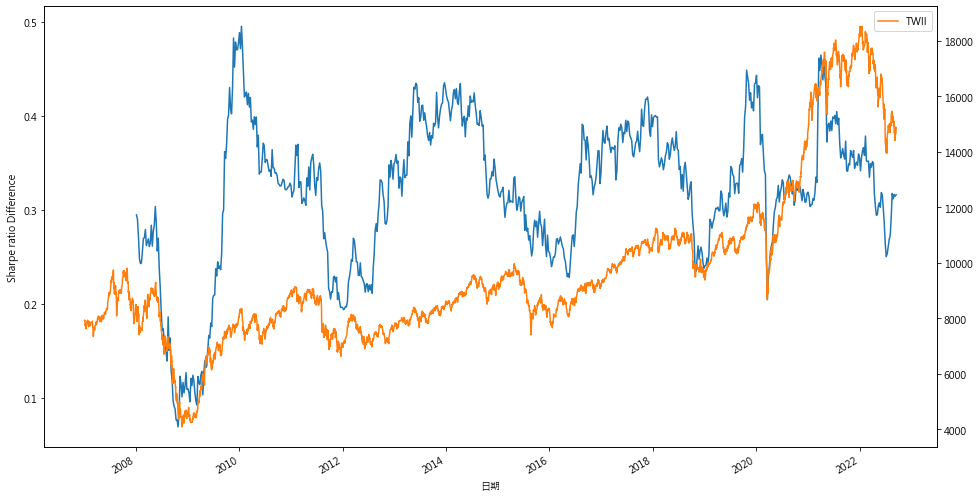

In [39]:
plt.figure(figsize=(16,9))
plt.xlabel("time")
plt.ylabel("Sharpe ratio Difference")

plt.plot(shar2, label = "Sharpe ratio")
data_dict["TWA00"]["還原收盤價"].plot(secondary_y =True, label = "TWII")
plt.legend()
plt.savefig('大盤與夏普')

# 所有策略部位變化與配置

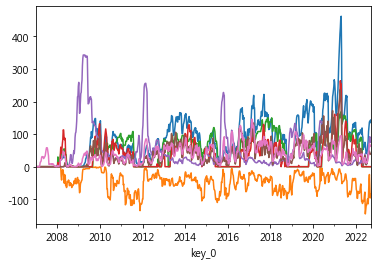

In [40]:
pz4.plot()#關鍵點
pzs4.plot()#放空
(夏普部位*6).plot()#強勢夏普
pvz4.plot()#量能
KD部位.plot()#低接
(MM部位*2).plot()#融資
外資4.plot()
plt.savefig('所有策略檔數')


<AxesSubplot:xlabel='key_0'>

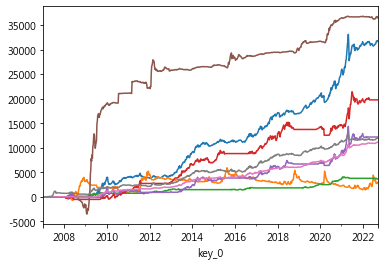

In [84]:
trr.sort_index().sum(axis = 1).cumsum().plot()
trrs.sort_index().sum(axis = 1).cumsum().plot()
(trr2330*20).sort_index().cumsum().plot()
(trrmsharpe.sort_index().sum(axis = 1).cumsum()*6).plot()
trrv.sort_index().sum(axis = 1).cumsum().plot()
trrkd.sort_index().sum(axis = 1).cumsum().plot()
(trrmm.sort_index().sum(axis = 1).cumsum()).plot()
trrtest.sort_index().sum(axis = 1).cumsum().plot()

# 淨部位變化

多空總部位 218.0


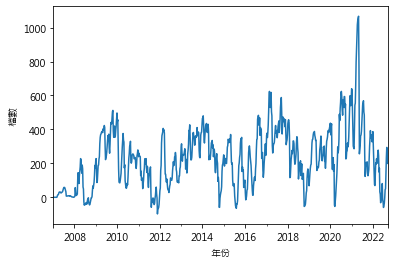

In [79]:
總部位變化 =  pz4 + pzs4 + (夏普部位*6) +pvz4 +KD部位  +MM部位+ 外資4
總部位變化.plot()
print('多空總部位',總部位變化[當週日期])
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('總部位變化水位')

In [43]:
總部位變化.tail(3)

key_0
2022-09-02    283.0
2022-09-09    218.0
2022-09-16    238.0
dtype: float64

# 混合策略損益

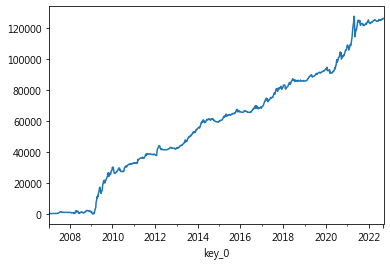

In [80]:
所有策略加總 = (tqt1*6) + trrsp + (trrv.sort_index().sum(axis = 1).cumsum()) +(trr2330*20) + (trr.sort_index().sum(axis = 1).cumsum()) + (trrkd.sort_index().sum(axis = 1).cumsum()) \
+ trrtest.sort_index().sum(axis = 1).cumsum() +(trrmm.sort_index().sum(axis = 1).cumsum())
所有策略加總.plot()
plt.savefig("所有策略加總")

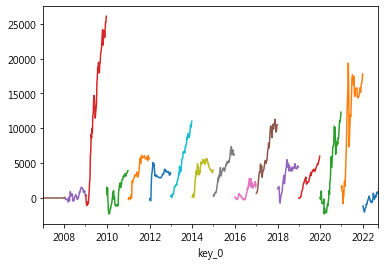

In [83]:
分年加總 = (trr.sort_index().sum(axis = 1)) + (trrs.sort_index().sum(axis = 1)) + (trrmsharpe.sort_index().sum(axis = 1))*6 + \
(trrv.sort_index().sum(axis = 1)) +(trrkd.sort_index().sum(axis = 1)) +(trrmm.sort_index().sum(axis = 1)) 
分年加總['2022'].cumsum().plot()
分年加總['2021'].cumsum().plot()
分年加總['2020'].cumsum().plot()
分年加總['2019'].cumsum().plot()
分年加總['2018'].cumsum().plot()
分年加總['2017'].cumsum().plot()
分年加總['2016'].cumsum().plot()
分年加總['2015'].cumsum().plot()
分年加總['2014'].cumsum().plot()
分年加總['2013'].cumsum().plot()
分年加總['2012'].cumsum().plot()
分年加總['2011'].cumsum().plot()
分年加總['2010'].cumsum().plot()
分年加總['2009'].cumsum().plot()
分年加總['2008'].cumsum().plot()
分年加總['2007'].cumsum().plot()

plt.savefig('分年損益')


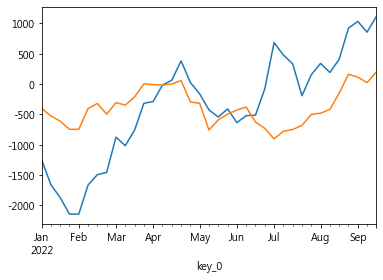

In [82]:
分年加總['2022'].cumsum().plot()
(trr['2022'].sort_index().sum(axis = 1).cumsum()).plot()
plt.savefig("前後比較")

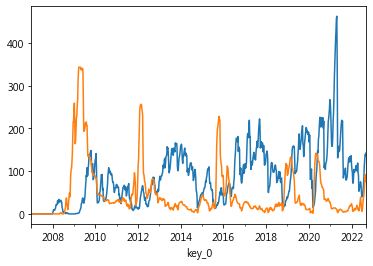

In [47]:
pz4.plot()#關鍵點
#pzs4.plot()
#(夏普部位*6).plot()
#pvz4.plot()
KD部位.plot()
#(MM部位*2).plot()
plt.savefig('檔數交會')

# 當週彙總整理

In [77]:
print("關鍵點買進標的")
print(關鍵點買進)
print("關鍵點買進檔數" , len(關鍵點買進))
print("關鍵點持有部位數目" , len(關鍵點持有部位))
print("關鍵點賣出標的")
print(關鍵點賣出)
print("關鍵點賣出檔數" , len(關鍵點賣出))
print("M夏普買進標的")
print(M夏普買進)
print("M夏普買進檔數" , len(M夏普買進))
print("M夏普持有部位數目" , len(M夏普持有部位))
print("M夏普賣出標的")
print(M夏普賣出)
print("M夏普賣出檔數" , len(M夏普賣出))
print("量能買進標的")
print(量能買進)
print("量能買進檔數" , len(量能買進))
print("量能持有部位數目" , len(量能持有部位))
print("量能賣出標的")
print(量能賣出)
print("量能賣出檔數" , len(量能賣出))
print("低接買進標的")
print(低接買進)
print("低接買進檔數" , len(低接買進))
print("低接持有部位數目" , len(低接持有部位))
print("低接賣出標的")
print(低接賣出)
print("低接賣出檔數" , len(低接賣出))
print("融資爆發買進標的")
print(MM買進)
print("融資爆發買進檔數" , len(MM買進))
print("融資爆發持有部位數目" , len(MM持有部位))
print("融資爆發賣出標的")
print(MM賣出)
print("融資爆發賣出檔數" , len(MM賣出))
print("外資買進標的")
print(外資買進)
print("外資買進檔數" , len(外資買進))
print("外資持有部位數目" , len(外資持有部位))
print("外資賣出標的")
print(外資賣出)
print("外資賣出檔數" , len(外資賣出))
print("空單放空標的")
print(空單放空)
print("空單放空檔數" , len(空單放空))
print("空單持有空單部位數目" , len(空單放空部位))
print("空單回補標的")
print(空單回補)


關鍵點買進標的
2105    1.0
2221    1.0
2483    1.0
4119    1.0
4155    1.0
4417    1.0
6139    1.0
6146    1.0
6245    1.0
6432    1.0
8088    1.0
Name: 2022-09-16 00:00:00, dtype: float64
關鍵點買進檔數 11
關鍵點持有部位數目 143
關鍵點賣出標的
2313    0.0
3303    0.0
Name: 2022-09-16 00:00:00, dtype: float64
關鍵點賣出檔數 2
M夏普買進標的
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
M夏普買進檔數 0
M夏普持有部位數目 0
M夏普賣出標的
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
M夏普賣出檔數 0
量能買進標的
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
量能買進檔數 0
量能持有部位數目 0
量能賣出標的
Series([], Name: 2022-09-16 00:00:00, dtype: float64)
量能賣出檔數 0
低接買進標的
2031    1.0
Name: 2022-09-16 00:00:00, dtype: float64
低接買進檔數 1
低接持有部位數目 75
低接賣出標的
3092    0.0
4760    0.0
5215    0.0
5474    0.0
6230    0.0
Name: 2022-09-16 00:00:00, dtype: float64
低接賣出檔數 5
融資爆發買進標的
1321    1.0
2467    1.0
Name: 2022-09-16 00:00:00, dtype: float64
融資爆發買進檔數 2
融資爆發持有部位數目 20
融資爆發賣出標的
4557    0.0
Name: 2022-09-16 00:00:00, dtype: float64
融資爆發賣出檔數 1
外資買進標的
1402    1.0
1717    1

In [78]:
pd.set_option('display.max_rows',None)
print('關鍵點持有部位')
print(list(關鍵點持有部位.index))
print('M夏普持有部位')
print(list(M夏普持有部位.index))
print('量能持有部位')
print(list(量能持有部位.index))
print('低接持有部位')
print(list(低接持有部位.index))
print('融資爆發持有部位')
print(list(MM持有部位.index))
print('空單持有部位')
print(list(空單放空部位.index))
print('外資持有部位')
print(list(外資持有部位.index))

關鍵點持有部位
['1104', '1215', '1218', '1319', '1321', '1336', '1339', '1342', '1402', '1410', '1444', '1451', '1503', '1513', '1525', '1537', '1582', '1712', '1720', '1733', '1736', '1752', '1786', '1789', '1813', '2065', '2066', '2105', '2206', '2211', '2221', '2228', '2301', '2362', '2402', '2474', '2483', '2488', '2534', '2539', '2548', '2707', '2729', '2752', '2754', '3002', '3022', '3090', '3209', '3293', '3380', '3454', '3531', '3564', '3596', '3617', '3703', '4104', '4105', '4107', '4111', '4119', '4129', '4155', '4163', '4417', '4438', '4506', '4532', '4536', '4543', '4550', '4557', '4566', '4763', '4766', '4906', '4908', '4915', '4974', '4977', '5015', '5225', '5278', '5284', '5288', '5353', '5388', '5426', '5489', '5534', '5704', '6115', '6139', '6146', '6153', '6176', '6183', '6221', '6227', '6245', '6263', '6279', '6285', '6409', '6432', '6469', '6472', '6570', '6579', '6605', '6613', '6666', '6690', '6703', '6727', '6768', '6803', '8049', '8050', '8069', '8072', '8083', '8088',

# 輸出WORD文本

In [50]:
from docx import Document
doc = Document()
doc.add_paragraph('HELLO.PYTHON')
#doc.save('test.docx')
doc.add_heading('我是一級標題')
doc.add_heading('我是二級標題',level = 2)
doc.add_heading('我是段落標題',level = 0)

document = Document()
paragraph = document.add_paragraph()
run1 = paragraph.add_run('我是粗體')
doc.save('test01.docx')

In [51]:
print("關鍵點買進標的",list(關鍵點買進.index))
#print("關鍵點賣出標的",list(關鍵點賣出.index))
print("M夏普買進標的",list(M夏普買進.index))
#print("M夏普賣出標的",list(M夏普賣出.index))
print("量能買進標的",list(量能買進.index))
#print("量能賣出標的",list(量能賣出.index))
print("低接買進標的",list(低接買進.index))
#print("低接賣出標的",list(低接賣出.index))
print("融資買進標的",list(MM買進.index))
#print("融資賣出標的",list(MM賣出.index))
#print("空單放空標的",list(空單放空.index))

print("外資買進標的",list(外資買進.index))
#print("外資賣出標的",list(外資賣出.index))
print("空單回補標的",list(空單回補.index))

關鍵點買進標的 ['1736', '2402', '3380', '4111', '4438', '6703', '9924', '9933']
M夏普買進標的 []
量能買進標的 []
低接買進標的 []
融資買進標的 ['4766', '5284', '9924', '9939']
外資買進標的 ['5284', '9924']
空單回補標的 ['2027', '2030', '2031', '2327', '3006', '3413', '3515', '6202', '8081']


In [52]:
#print("關鍵點買進標的",list(關鍵點買進.index))
print("關鍵點賣出標的",list(關鍵點賣出.index))
#print("M夏普買進標的",list(M夏普買進.index))
print("M夏普賣出標的",list(M夏普賣出.index))
#print("量能買進標的",list(量能買進.index))
print("量能賣出標的",list(量能賣出.index))
#print("低接買進標的",list(低接買進.index))
print("低接賣出標的",list(低接賣出.index))
#print("融資買進標的",list(MM買進.index))
print("融資賣出標的",list(MM賣出.index))
print("空單放空標的",list(空單放空.index))

#print("外資買進標的",list(外資買進.index))
print("外資賣出標的",list(外資賣出.index))
#print("空單回補標的",list(空單回補.index))

關鍵點賣出標的 ['1514', '1522', '2493', '3218', '3479', '3665', '6109', '6146', '6442', '8114', '8374', '8433', '8941']
M夏普賣出標的 []
量能賣出標的 []
低接賣出標的 ['1802', '2399', '3438', '3484', '3530', '3540', '4909', '6120', '6203', '6223', '6552', '6732', '9951']
融資賣出標的 ['1451', '1535', '1733', '6139', '6167', '9930']
空單放空標的 ['2329', '2337', '2354', '2455', '2457', '2607', '3016', '3035', '3041', '3042', '3059', '3141', '3217', '3260', '3317', '3526', '3527', '3624', '3675', '3708', '3714', '4919', '4927', '4961', '4976', '5285', '5299', '6182', '6217', '6223', '6237', '6257', '6274', '6278', '6411', '6435', '6679', '6732', '6756', '8016', '8027', '8155', '8213', '8215', '8255', '8924']
外資賣出標的 ['1229', '1304', '1473', '1717', '2704', '3041', '3218', '3673']


# 寫入WORD

In [53]:
from docx import Document

def view_docs(docx_file):
    # 打開文檔1
    doc = Document(docx_file)
    # 讀取每段內容
    pl = [ paragraph.text for paragraph in doc.paragraphs]
    # 輸出讀取到的內容
    for i in pl:
        print(i)
def view_docs_table(docx_file):
    # 打開文檔1
    doc = Document(docx_file)
    # 讀取每段內容
    tables = [table for table in doc.tables]
    for table in tables:
        for row in table.rows:
            for cell in row.cells:
                print(cell.text, end='  ')
            print()
        print('\n')


if __name__ == '__main__':
    view_docs("每週股票報表.docx")
    view_docs_table("每週股票報表.docx")

日期：2022/09/12

關鍵點買進標的 ['1736', '2402', '3380', '4111', '4438', '6703', '9924', '9933']
關鍵點賣出標的 ['1514', '1522', '2493', '3218', '3479', '3665', '6109', '6146', '6442', '8114', '8374', '8433', '8941']
M夏普買進標的 []
M夏普賣出標的 []
量能買進標的 []
量能賣出標的 []
低接買進標的 []
低接賣出標的 ['1802', '2399', '3438', '3484', '3530', '3540', '4909', '6120', '6203', '6223', '6552', '6732', '9951']
融資買進標的 ['4766', '5284', '9924', '9939']
融資賣出標的 ['1451', '1535', '1733', '6139', '6167', '9930']
空單放空標的 ['2329', '2337', '2354', '2455', '2457', '2607', '3003', '3016', '3035', '3041', '3042', '3059', '3081', '3217', '3260', '3317', '3526', '3527', '3708', '3714', '4927', '4961', '4976', '5285', '6182', '6217', '6223', '6237', '6278', '6414', '6679', '6732', '8016', '8027', '8155', '8213', '8215', '8255', '8924']
空單回補標的 ['2027', '2030', '2031', '2327', '2351', '3006', '3019', '3026', '3034', '3413', '3515', '3546', '3704', '5289', '6147', '6202', '6531', '8081', '8436']
  單檔金額  本週增加  本週減少  模型組數  投入金額  
關鍵點  50  8  -13  135  6750

# 育儀每週需求資料

In [169]:
import math
育儀檔DF = pd.DataFrame()
育儀檔DF['空單賣出標的'] = list(空單放空.index)
lsws=[]
張數=[]
for i in range(len(育儀檔DF)):
    lsws.append(DDW[育儀檔DF.iloc[i,0]].tail(1).iloc[0,3])
育儀檔DF['空單賣出收盤價'] = lsws
for l in range(len(育儀檔DF)):
    張數 = 500000/(育儀檔DF['空單賣出收盤價']*1000)
floormethod = lambda x :math.floor(x)

育儀檔DF['需求張數'] = 張數.apply(floormethod)

育儀檔DF
育儀檔DF.to_excel('每週空單需求.xlsx')

# 每週買賣總表

In [184]:
每週買DF = pd.DataFrame()
每週買DF = pd.concat([每週買DF,pd.DataFrame(關鍵點買進.index,columns = ['關鍵點買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(關鍵點賣出.index,columns = ['關鍵點賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(M夏普買進.index,columns = ['M夏普買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(M夏普賣出.index,columns = ['M夏普賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(量能買進.index,columns = ['量能買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(量能賣出.index,columns = ['量能賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(低接買進.index,columns = ['低接買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(低接賣出.index,columns = ['低接賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(MM買進.index,columns = ['融資買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(MM賣出.index,columns = ['融資賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(外資買進.index,columns = ['外資買進'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(外資賣出.index,columns = ['外資賣出'])],axis=1)
每週買DF = pd.concat([每週買DF,pd.DataFrame(空單放空.index,columns = ['空單放空'])],axis=1)
#每週買DF = pd.concat([每週買DF,pd.DataFrame(空單回補.index,columns = ['空單回補'])],axis=1)
每週買DF

,關鍵點買進,M夏普買進,量能買進,低接買進,融資買進,外資買進,空單放空
0,2105,NaN,NaN,2031,1321,1402,3221
1,2221,NaN,NaN,NaN,2467,1717,6491
2,2483,NaN,NaN,NaN,NaN,5457,NaN
3,4119,NaN,NaN,NaN,NaN,6139,NaN
4,4155,NaN,NaN,NaN,NaN,6269,NaN
5,4417,NaN,NaN,NaN,NaN,6612,NaN
6,6139,NaN,NaN,NaN,NaN,9938,NaN
7,6146,NaN,NaN,NaN,NaN,NaN,NaN
8,6245,NaN,NaN,NaN,NaN,NaN,NaN
9,6432,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
每週買DF.to_excel('每週買進總表.xlsx')

In [186]:
每週賣DF = pd.DataFrame()
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(關鍵點買進.index,columns = ['關鍵點買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(關鍵點賣出.index,columns = ['關鍵點賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(M夏普買進.index,columns = ['M夏普買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(M夏普賣出.index,columns = ['M夏普賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(量能買進.index,columns = ['量能買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(量能賣出.index,columns = ['量能賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(低接買進.index,columns = ['低接買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(低接賣出.index,columns = ['低接賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(MM買進.index,columns = ['融資買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(MM賣出.index,columns = ['融資賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(外資買進.index,columns = ['外資買進'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(外資賣出.index,columns = ['外資賣出'])],axis=1)
#每週賣DF = pd.concat([每週賣DF,pd.DataFrame(空單放空.index,columns = ['空單放空'])],axis=1)
每週賣DF = pd.concat([每週賣DF,pd.DataFrame(空單回補.index,columns = ['空單回補'])],axis=1)
每週賣DF


,關鍵點賣出,M夏普賣出,量能賣出,低接賣出,融資賣出,外資賣出,空單回補
0,2313,NaN,NaN,3092,4557,1503,2329
1,3303,NaN,NaN,4760,NaN,2504,2457
2,NaN,NaN,NaN,5215,NaN,3023,2607
3,NaN,NaN,NaN,5474,NaN,6283,3016
4,NaN,NaN,NaN,6230,NaN,NaN,3217
5,NaN,NaN,NaN,NaN,NaN,NaN,3260
6,NaN,NaN,NaN,NaN,NaN,NaN,3526
7,NaN,NaN,NaN,NaN,NaN,NaN,3704
8,NaN,NaN,NaN,NaN,NaN,NaN,3714
9,NaN,NaN,NaN,NaN,NaN,NaN,4968


In [187]:
每週賣DF.to_excel('每週賣出總表.xlsx')